# Final Version


<div class="header">
    <div class="title">
    <h1>Chemoinformatics‑based enumeration of chemical libraries</h1>
    </div>
    <div class="authors">
        Shiyao Ju (419866)<br/>
        Yunlong Bai (417936)<br/>
    </div>
    <div class="logo">
    <img src="https://www.modes.rwth-aachen.de/global/show_picture.asp?id=aaaaaaaabpnsrxy", style="position: absolute; top: 0; right: 0;", width=600, heigth=600>
    </div>
    Any questions please contact shi.yao.ju@rwth-aachen.de
</div>

Please make sure you have the following libraries installed before running!!!   
pip install rdkit  
pip install pandas  
pip install Jinja2

In [1]:
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit import Chem
import pandas as pd
import base64
from IPython.display import display, HTML
import os
import shutil

In [2]:
# Define an empty dictionary to operate on the data
class Data:
    def __init__(self):  # Initialize dictionary
        self.data = {}

    def add_data(self, data_name, data_value):  # Add data with different names
        self.data[data_name] = data_value


# Operations related to image processing
def mkdir(new_folder_name):  # Create folder
    current_directory = os.getcwd()
    new_folder_path = os.path.join(current_directory, new_folder_name)
    os.mkdir(new_folder_path)


def deletedir(folder_name):  # Delete folder
    current_directory = os.getcwd()
    folder_path = os.path.join(current_directory, folder_name)
    shutil.rmtree(folder_path)


def detectdir(folder_name):  # Identify whether a folder exists in the current path
    current_directory = os.getcwd()
    folder_path = os.path.join(current_directory, folder_name)
    if os.path.exists(folder_path):
        return False
    else:
        return True


# Image encoding
def img_read(image_path, SCALING_FACTOR):
    with open(image_path, "rb") as image_file:
        encoded_image = base64.b64encode(image_file.read()).decode('utf-8')
        # Change the size of the image displayed in the table
        width = 400 / SCALING_FACTOR 
        height = 400 / SCALING_FACTOR
        return '<img src="data:image/jpeg;base64,{} "width="{}" height="{}">'.format(encoded_image, width, height)


# Check if Smiles has this substructure
def SubstructMatch(Smiles, Smarts):
    mol = Chem.MolFromSmiles(Smiles)
    patt = Chem.MolFromSmarts(Smarts)
    if mol.HasSubstructMatch(patt):
        print("Smiles has this substructure")
    else: 
        print("Smiles does not have this substructure")


# Convert smiles to smarts, including common elements. Can be supplemented by yourself
def Smiles_to_Smarts(Smiles):
    mol = Chem.MolFromSmiles(Smiles)
    smarts = Chem.MolToSmarts(mol)
    smarts_repalce = smarts.replace('#6', 'C').replace('#7', 'N').replace('#8', 'O').replace('#9', 'F').replace('#11', 'Na').replace('#15', 'P').replace('#16', 'S').replace('#17', 'Cl').replace('#35', 'Br').replace('#53', 'I')
    print(smarts_repalce)


# Visualize the structure of smiles
def Molecular_visualization(Smiles):
    mol = Chem.MolFromSmiles(Smiles)
    img = Chem.Draw.MolToImage(mol, size=(300, 300))
    display(img)


# Visualize the Pattern
def Pattern_visualization(Pattern):
    reaction_pattern = Pattern
    rxn = AllChem.ReactionFromSmarts(reaction_pattern)
    img = Chem.Draw.ReactionToImage(rxn, subImgSize=(300, 300))
    display(img)

# Convert smiles to sdf file
def convert_smiles_to_2d_sdf(smiles_file, output_file):
    with open(smiles_file, 'r') as f:
        smiles_list = f.read().splitlines()
    writer = Chem.SDWriter(output_file)
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        AllChem.Compute2DCoords(mol)
        writer.write(mol)
    writer.close()
    print("saved as:", output_file)


# The core of this file, used for enumeration library generation
def Enum_library_generation(Reactants_Path, Pattern_Path):
    ADD_COLUMN = 1  # Used to add a new column in the table
    SCALING_FACTOR = 1  # For image scaling
    COLUMN_Number = 0  # The number of columns in the table
    CURRENT_NUMBER =0  # Current column
    
    # Generate an instance, add different data names
    data_instance = Data()
    data_instance.add_data('Reactants_Smiles', [])
    data_instance.add_data('Pattern', [])

    # Read Reactants from txt-file
    file_path = Reactants_Path
    with open(file_path, "r") as file:
        for line in file:
            data_instance.data['Reactants_Smiles'].append(line.strip())
    
    # Read Pattern from txt-file
    file_path = Pattern_Path
    with open(file_path, "r") as file:
        for line in file:
            if line.startswith('#'):
                continue
            data_instance.data['Pattern'].append(line.strip())
    
    # Continue to add data names and initialize
    data_instance.add_data('Reactants', [None] * len(data_instance.data['Reactants_Smiles']))
    data_instance.add_data('Products', [None] * len(data_instance.data['Reactants_Smiles']))
    data_instance.add_data('Products_Smiles', [None] * len(data_instance.data['Reactants_Smiles']))
    data_instance.add_data('Pattern_Number', ['0'] * len(data_instance.data['Reactants_Smiles']))

    # Create a folder for temporary storage of pictures
    if detectdir("picture") == True:
        mkdir("picture")

    # Input data through iterative loop
    for i in range(0, len(data_instance.data['Reactants_Smiles'])):        
        reactant = Chem.MolFromSmiles(data_instance.data['Reactants_Smiles'][i])  # Convert Smiles to Mol so that it can be processed with RDkit
        img = Chem.Draw.MolToImage(reactant, size=(300, 300))
        data_instance.data['Reactants'][i] = ["./picture/Reactants"+ str(i) + ".png"]  
        img.save("./picture/Reactants"+ str(i) + ".png")  # Save Reactant Image
        
        for j in range(0, len(data_instance.data['Pattern'])):
            reaction_pattern = data_instance.data['Pattern'][j]  # Define the Pattern used by Reaction
            rxn = AllChem.ReactionFromSmarts(reaction_pattern)  # Define reactor
            products = rxn.RunReactants([reactant])  # Get the resulting product
            uni_products = list(set(Chem.MolToSmiles(products[i][0]) for i in range(0, len(products))))  # Remove duplicate products due to symmetry
            
            # Store information into a dictionary based on the result
            if len(uni_products) != 0:
                if data_instance.data['Products_Smiles'][i] == None:
                    data_instance.data['Products_Smiles'][i] = uni_products
                    for x in range(0, len(data_instance.data['Products_Smiles'][i])):
                        if x == 0:
                            data_instance.data['Pattern_Number'][i] = [j+1]
                        else:
                            data_instance.data['Pattern_Number'][i].append(j+1)
                else:
                    for x in range(0, len(uni_products)):
                        data_instance.data['Products_Smiles'][i].append(uni_products[x])
                        data_instance.data['Pattern_Number'][i].append(j+1)
                if len(data_instance.data['Products_Smiles'][i]) == 1:
                    img = Chem.Draw.MolToImage(Chem.MolFromSmiles(uni_products[0]), size=(300, 300))
                    data_instance.data['Products'][i] = ["./picture/Products"+ str(i) + ".png"]
                    img.save("./picture/Products"+ str(i) + ".png")
                elif len(data_instance.data['Products_Smiles'][i]) > 1:
                    for k in range(0, len(uni_products)):
                        img = Chem.Draw.MolToImage(Chem.MolFromSmiles(uni_products[k]), size=(300, 300))
                        if data_instance.data['Products'][i] == None:
                            data_instance.data['Products'][i] = ["./picture/Products"+ str(i) + str(k+1) + ".png"]
                        else:
                            data_instance.data['Products'][i].append("./picture/Products"+ str(i) + str(k+1) + ".png")
                        img.save("./picture/Products"+ str(i) + str(k+1) + ".png")
                        if len(data_instance.data['Products_Smiles'][i]) > COLUMN_Number:
                            COLUMN_Number = len(data_instance.data['Products_Smiles'][i])
        
        # Columns of the table with molecules that generate the most products
        if COLUMN_Number > SCALING_FACTOR:
            SCALING_FACTOR  = COLUMN_Number
    
    # Initialize a new dictionary for visualization using tables
    data = {'Reactants': [None] * len(data_instance.data['Reactants_Smiles']),
        'Reactants_Smiles': [None] * len(data_instance.data['Reactants_Smiles']),
        'Pattern_Number_1': ['0'] * len(data_instance.data['Reactants_Smiles']),
        'Products_1': [None] * len(data_instance.data['Reactants_Smiles']),
        'Products_Smiles_1': [None] * len(data_instance.data['Reactants_Smiles'])}

    # Maps the elements in the dictionary storing the information to the newly defined dictionary in
    for i in range(0, COLUMN_Number):
        for j in range(0,len(data_instance.data['Reactants_Smiles'])):
            if i == 0:
                data['Reactants_Smiles'][j] = data_instance.data['Reactants_Smiles'][j]
                data['Reactants'][j] = img_read(data_instance.data['Reactants'][j][0], SCALING_FACTOR)
            if data_instance.data['Products'][j] != None:
                if CURRENT_NUMBER == 0:
                    data['Products_1'][j] = img_read(data_instance.data['Products'][j][0], SCALING_FACTOR)
                    data['Products_Smiles_1'][j] = data_instance.data['Products_Smiles'][j][0]
                    data['Pattern_Number_1'][j] = data_instance.data['Pattern_Number'][j][0]
                else:
                    if CURRENT_NUMBER == ADD_COLUMN:
                        Element_Pattern = ['0'] * len(data_instance.data['Reactants_Smiles'])
                        Element_Products = [None] * len(data_instance.data['Reactants_Smiles'])
                        Element_Products_Smiles = [None] * len(data_instance.data['Reactants_Smiles'])
                        ADD_COLUMN = ADD_COLUMN + 1
                    if len(data_instance.data['Products'][j]) >= CURRENT_NUMBER + 1:
                        Element_Pattern[j] = data_instance.data['Pattern_Number'][j][CURRENT_NUMBER]
                        Element_Products[j] = img_read(data_instance.data['Products'][j][CURRENT_NUMBER], SCALING_FACTOR)
                        Element_Products_Smiles[j] = data_instance.data['Products_Smiles'][j][CURRENT_NUMBER]
        if i != 0:
            data.update({'Pattern_Number_' + str(CURRENT_NUMBER+1): Element_Pattern})
            data.update({'Products_' + str(CURRENT_NUMBER+1): Element_Products})
            data.update({'Products_Smiles_' + str(CURRENT_NUMBER+1): Element_Products_Smiles})
        CURRENT_NUMBER = CURRENT_NUMBER + 1

    # Print the graph to output
    df = pd.DataFrame(data)
    display(HTML(df.to_html(escape=False)))

    # Delete the folder used to temporarily store pictures
    if detectdir("picture") == False:
        deletedir("picture")

<div>
<h2>Usecase: Redox reactions of quinones<h2>
</div>
p.s. Pattern_Number equals to 0 means no reaction

,Reactants,Reactants_Smiles,Pattern_Number_1,Products_1,Products_Smiles_1,Pattern_Number_2,Products_2,Products_Smiles_2,Pattern_Number_3,Products_3,Products_Smiles_3
0,,O=C1C(=O)C=CC=C1,6,,Oc1ccccc1O,0,None,None,0,None,None
1,,O=C1C=CC(=O)C=C1,1,,Oc1ccc(O)cc1,0,None,None,0,None,None
2,,O=C1C=CC(=O)c(c12)cccc2,2,,Oc1ccc(O)c2ccccc12,0,None,None,0,None,None
3,,c1cccc(c12)C(=O)c3c(C2=O)cccc3,3,,Oc1c2ccccc2c(O)c2ccccc12,0,None,None,0,None,None
4,,O=S(=O)(O)c(c1O)ccc(c12)C(=O)c3c(C2=O)ccc(c3O)S(=O)(=O)O,3,,O=S(=O)(O)c1ccc2c(O)c3c(O)c(S(=O)(=O)O)ccc3c(O)c2c1O,0,None,None,0,None,None
5,,c1cc(S(=O)(=O)O)cc(c12)C(=O)c3c(C2=O)ccc(c3)S(=O)(=O)O,3,,O=S(=O)(O)c1ccc2c(O)c3ccc(S(=O)(=O)O)cc3c(O)c2c1,0,None,None,0,None,None
6,,c1cccc(C2=O)c1C(=O)c(c23)cc(cc3)S(=O)(=O)O,3,,O=S(=O)(O)c1ccc2c(O)c3ccccc3c(O)c2c1,0,None,None,0,None,None
7,,c1cccc(C2=O)c1C(=O)c(c23)cc(S(=O)(=O)O)c(O)c3O,3,,O=S(=O)(O)c1cc2c(O)c3ccccc3c(O)c2c(O)c1O,7,,O=C1C(=O)C2=C(C=C1S(=O)(=O)O)C(=O)c1ccccc1C2=O,0,None,None
8,,c1cccc(C2=O)c1C(=O)c(c23)c(O)c(CS(=O)(=O)O)c(c3O)CS(=O)(=O)O,3,,O=S(=O)(O)Cc1c(CS(=O)(=O)O)c(O)c2c(O)c3ccccc3c(O)c2c1O,5,,O=C1C(CS(=O)(=O)O)=C(CS(=O)(=O)O)C(=O)C2=C1C(=O)c1ccccc1C2=O,0,None,None
9,,c1cc(S(=O)(=O)O)c(O)c(c12)C(=O)c3c(C2=O)ccc(c3O)S(=O)(=O)O,3,,O=S(=O)(O)c1ccc2c(O)c3ccc(S(=O)(=O)O)c(O)c3c(O)c2c1O,0,None,None,0,None,None

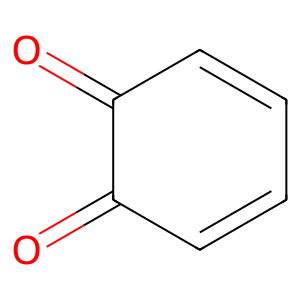
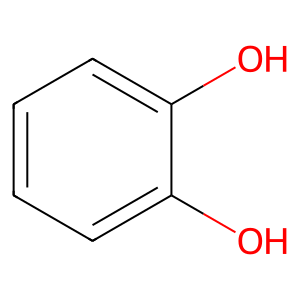
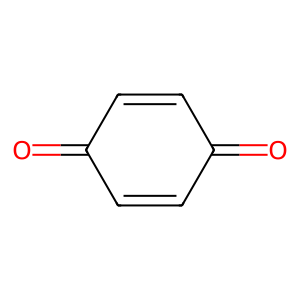
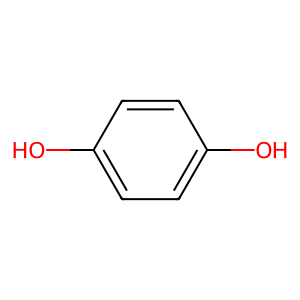
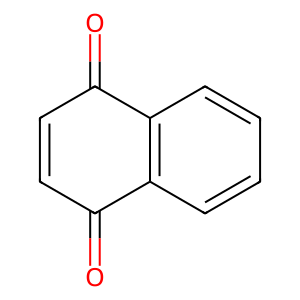
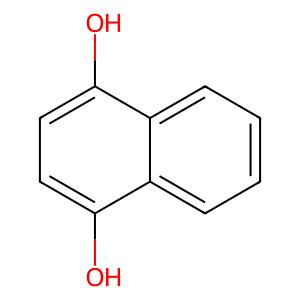
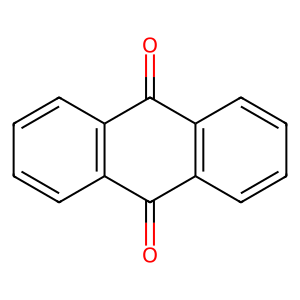
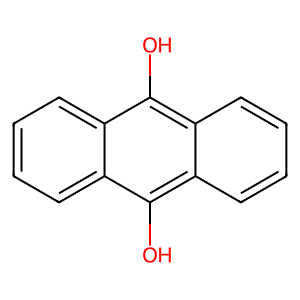
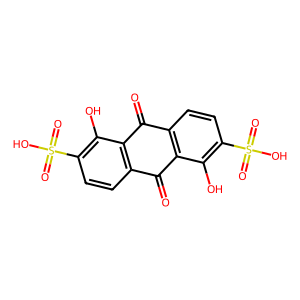
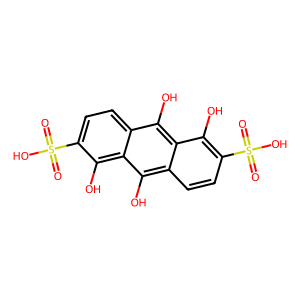
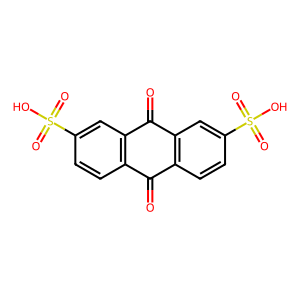
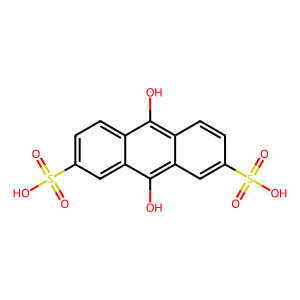
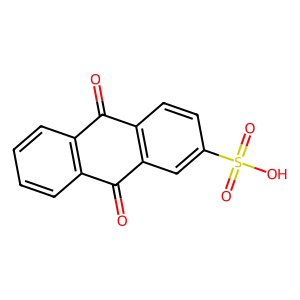
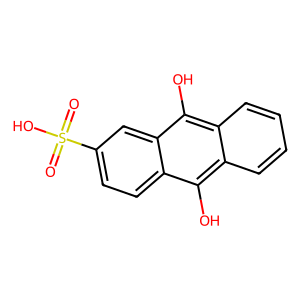
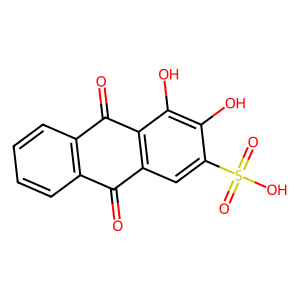
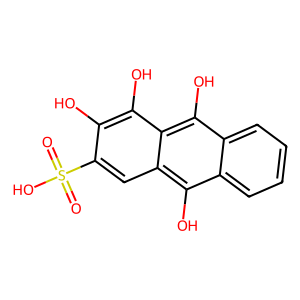
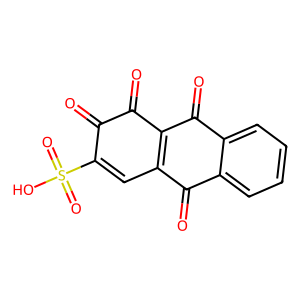
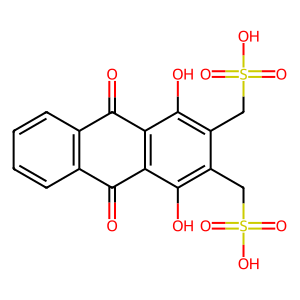
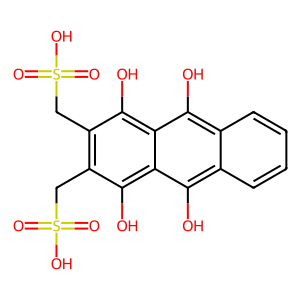
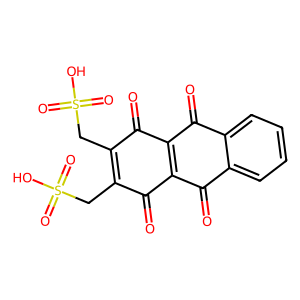
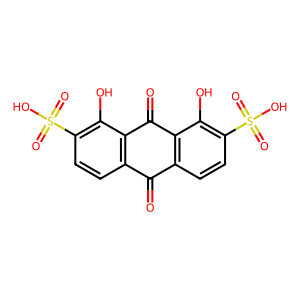
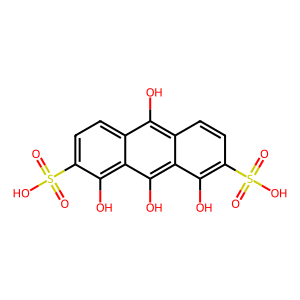
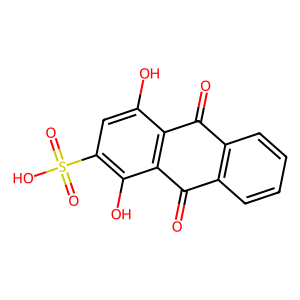
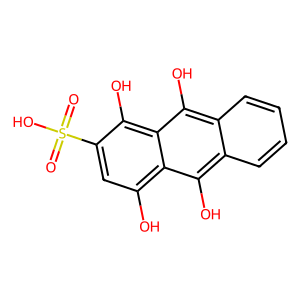
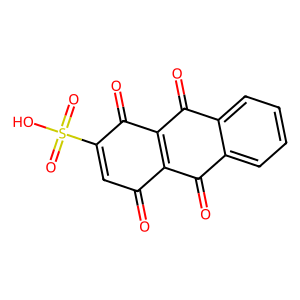
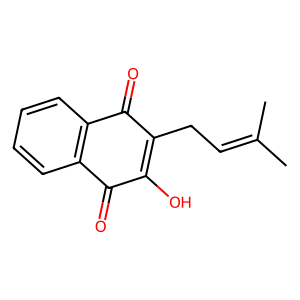
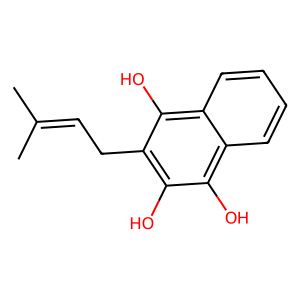
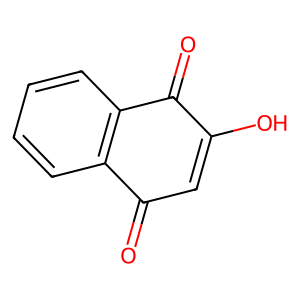
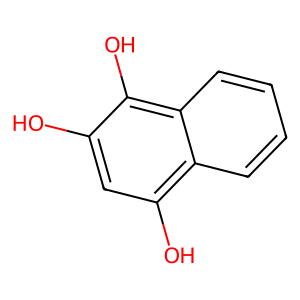
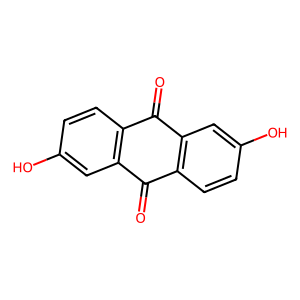
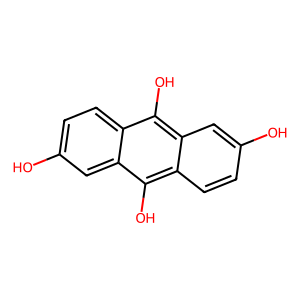
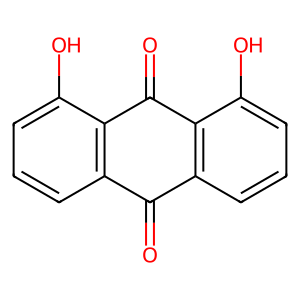
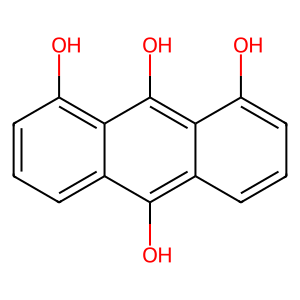
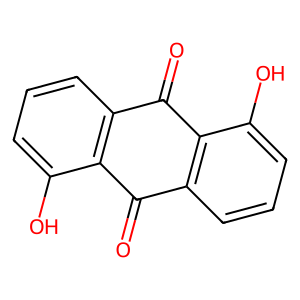
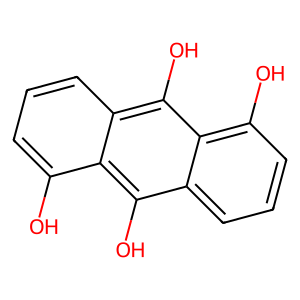
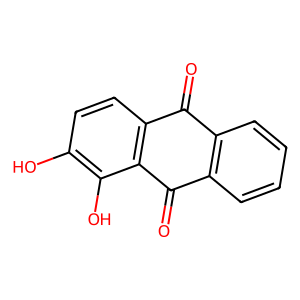
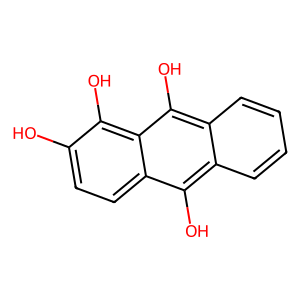
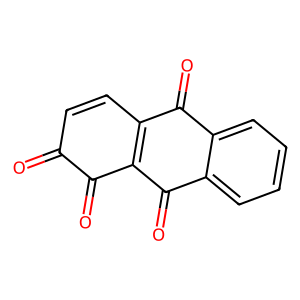
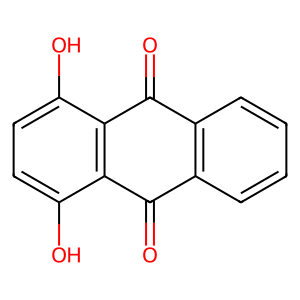
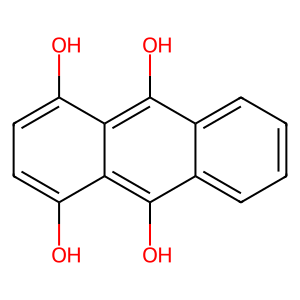
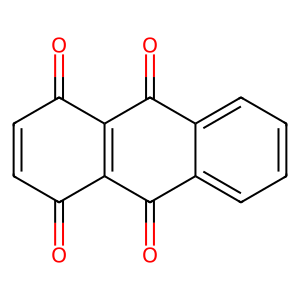
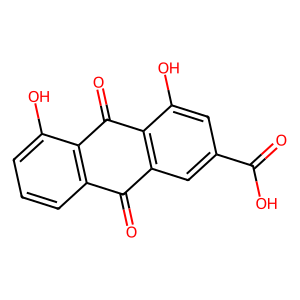
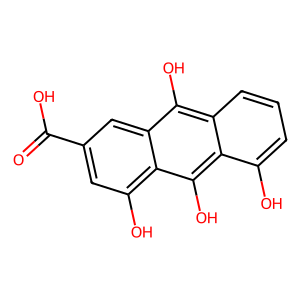
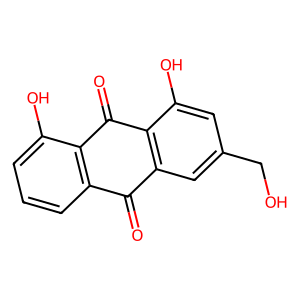
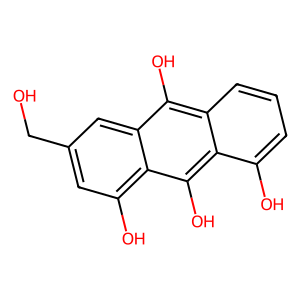
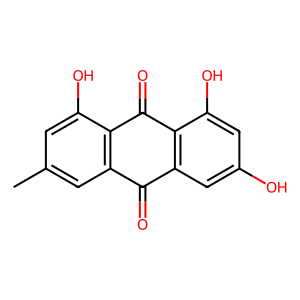
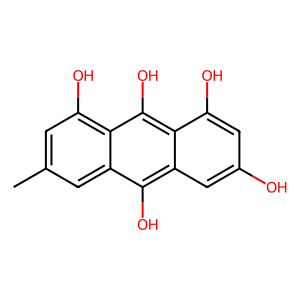
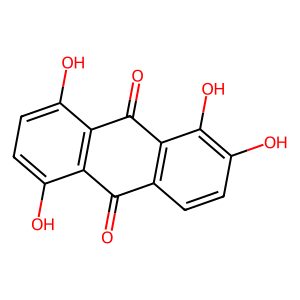
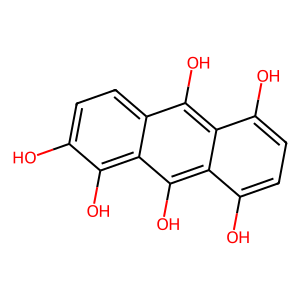
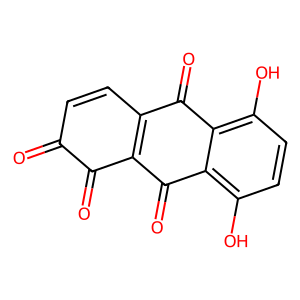
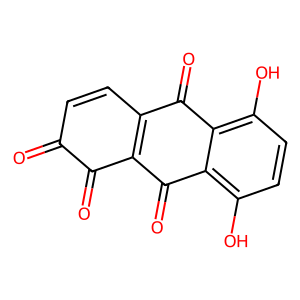
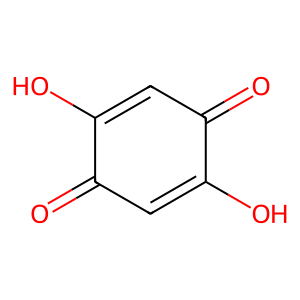
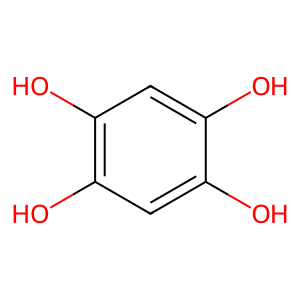
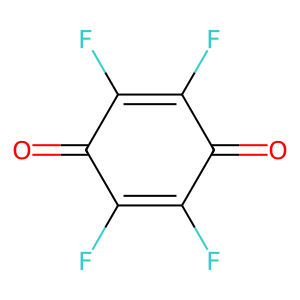
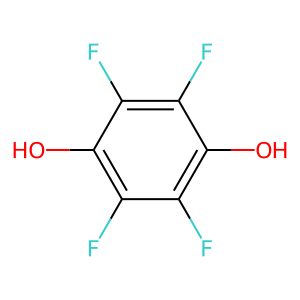
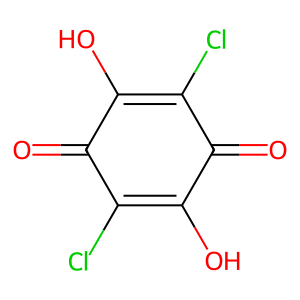
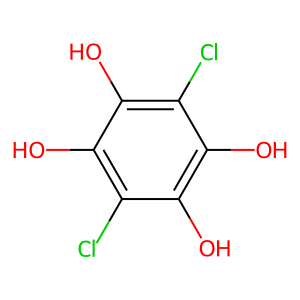
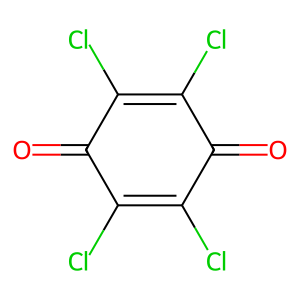
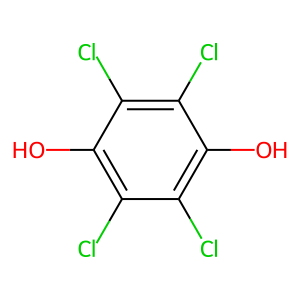
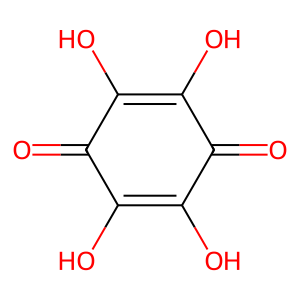
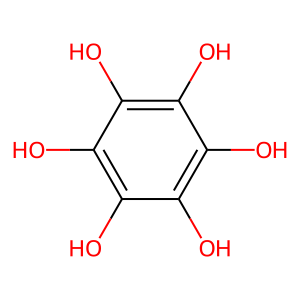
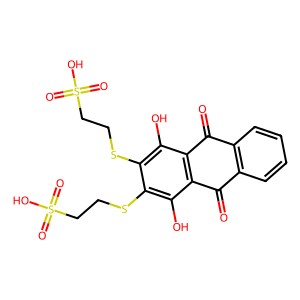
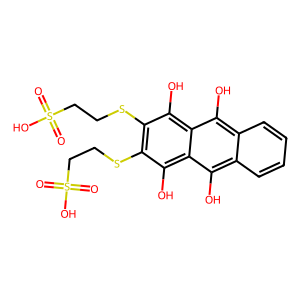
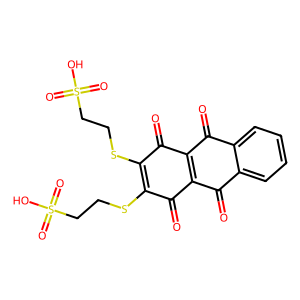
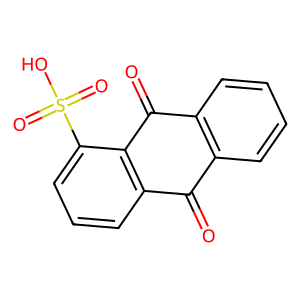
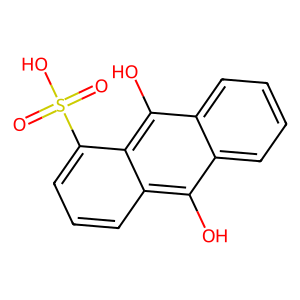
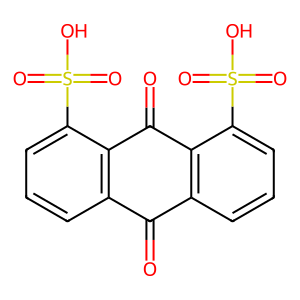
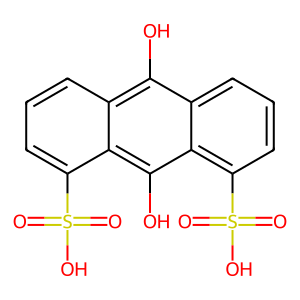
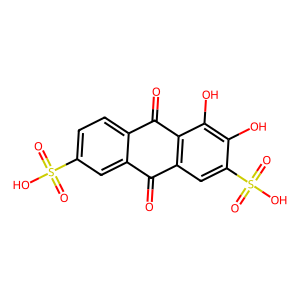
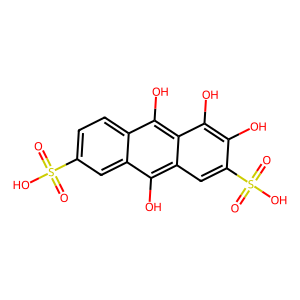
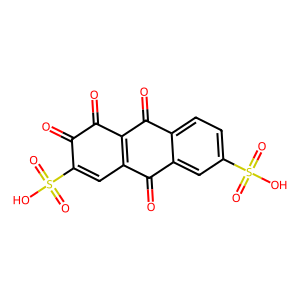
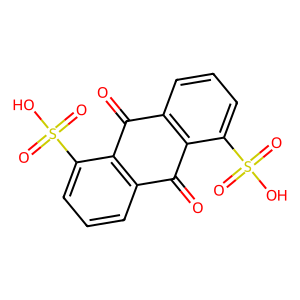
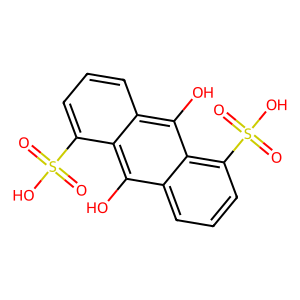
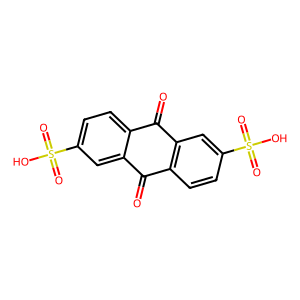
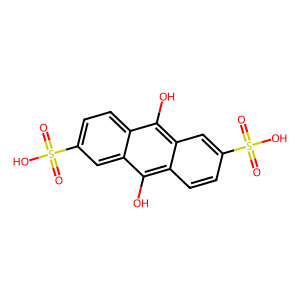
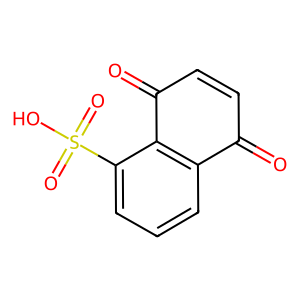
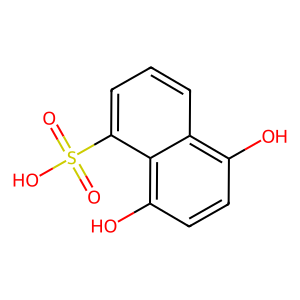
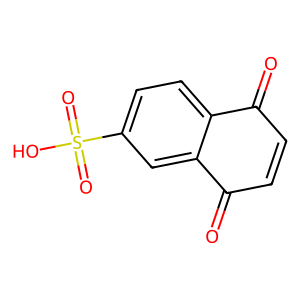
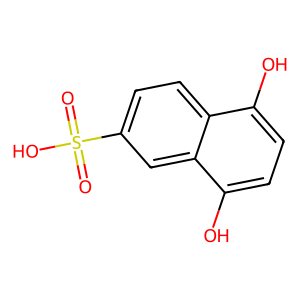
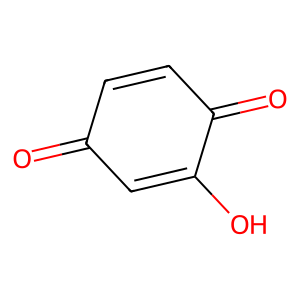
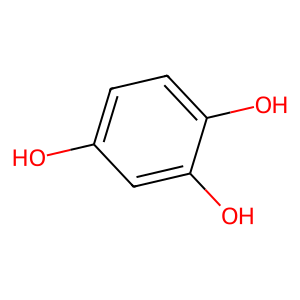
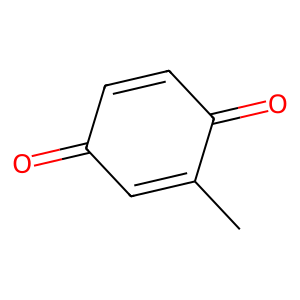
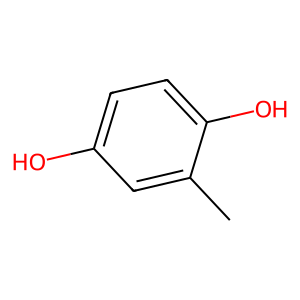
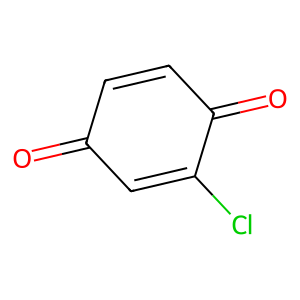
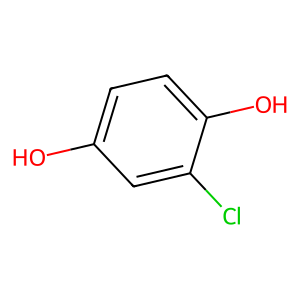
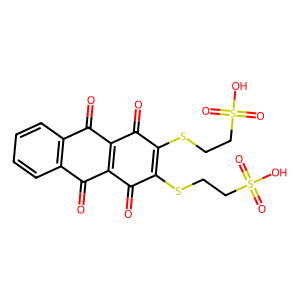
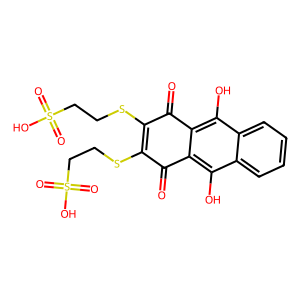
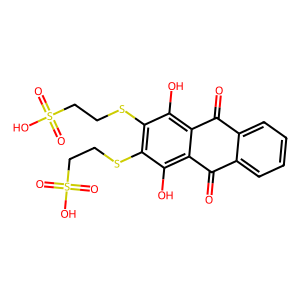
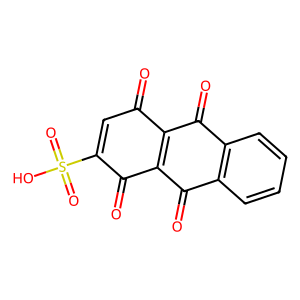
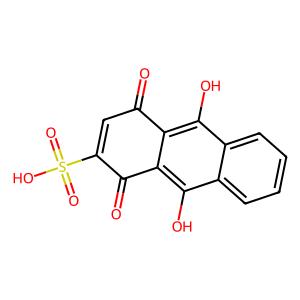
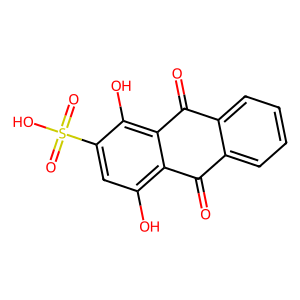

In [3]:
Reactants_Path = './input/Reactants_reduction.txt'
Pattern_Path = './input/Pattern.txt'

Enum_library_generation(Reactants_Path, Pattern_Path)

,Reactants,Reactants_Smiles,Pattern_Number_1,Products_1,Products_Smiles_1,Pattern_Number_2,Products_2,Products_Smiles_2,Pattern_Number_3,Products_3,Products_Smiles_3
0,,Oc1ccccc1O,7,,O=C1C=CC=CC1=O,0,None,None,0,None,None
1,,Oc1ccc(O)cc1,5,,O=C1C=CC(=O)C=C1,0,None,None,0,None,None
2,,Oc1ccc(O)c2ccccc12,5,,O=C1C=CC(=O)c2ccccc=21,0,None,None,0,None,None
3,,Oc1c2ccccc2c(O)c2ccccc12,5,,O=C1c2ccccc=2C(=O)c2ccccc=21,0,None,None,0,None,None
4,,O=S(=O)(O)c1ccc2c(O)c3c(O)c(S(=O)(=O)O)ccc3c(O)c2c1O,5,,O=C1c2ccc(S(=O)(=O)O)c(O)c=2C(=O)c2ccc(S(=O)(=O)O)c(O)c=21,0,None,None,0,None,None
5,,O=S(=O)(O)c1ccc2c(O)c3ccc(S(=O)(=O)O)cc3c(O)c2c1,5,,O=C1c2ccc(S(=O)(=O)O)cc=2C(=O)c2cc(S(=O)(=O)O)ccc=21,0,None,None,0,None,None
6,,O=S(=O)(O)c1ccc2c(O)c3ccccc3c(O)c2c1,5,,O=C1c2ccccc=2C(=O)c2cc(S(=O)(=O)O)ccc=21,0,None,None,0,None,None
7,,O=S(=O)(O)c1cc2c(O)c3ccccc3c(O)c2c(O)c1O,5,,O=C1c2ccccc=2C(=O)c2c(O)c(O)c(S(=O)(=O)O)cc=21,7,,O=C1C(=O)c2c(O)c3ccccc3c(O)c=2C=C1S(=O)(=O)O,0,None,None
8,,O=S(=O)(O)Cc1c(CS(=O)(=O)O)c(O)c2c(O)c3ccccc3c(O)c2c1O,5,,O=C1c2ccccc=2C(=O)c2c(O)c(CS(=O)(=O)O)c(CS(=O)(=O)O)c(O)c=21,5,,O=C1C(CS(=O)(=O)O)=C(CS(=O)(=O)O)C(=O)c2c(O)c3ccccc3c(O)c=21,0,None,None
9,,O=S(=O)(O)c1ccc2c(O)c3ccc(S(=O)(=O)O)c(O)c3c(O)c2c1O,5,,O=C1c2ccc(S(=O)(=O)O)c(O)c=2C(=O)c2c(O)c(S(=O)(=O)O)ccc=21,0,None,None,0,None,None

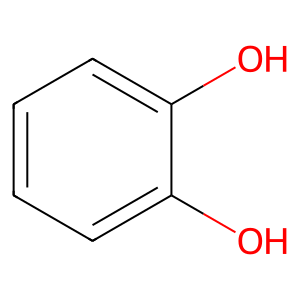
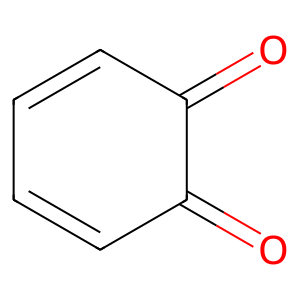
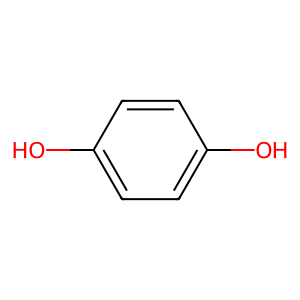
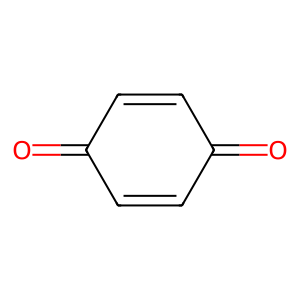
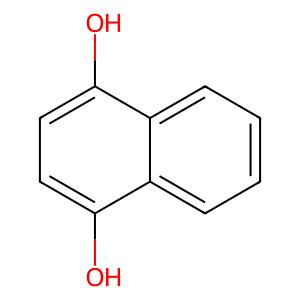
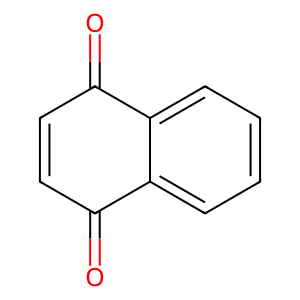
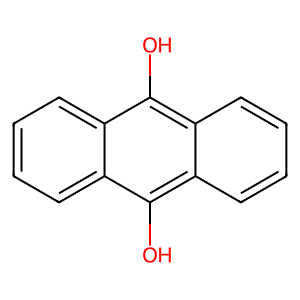
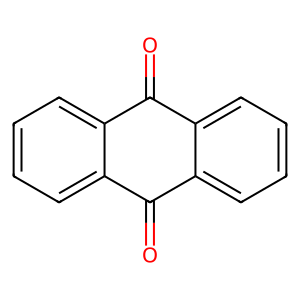
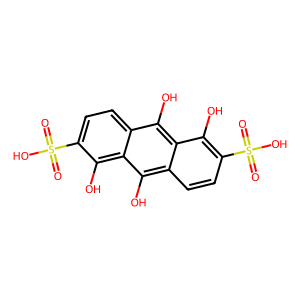
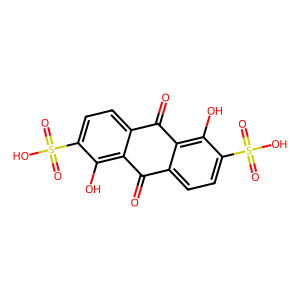
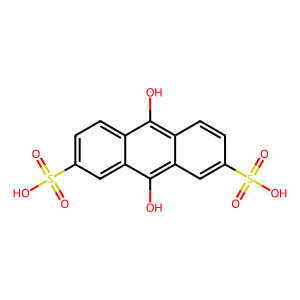
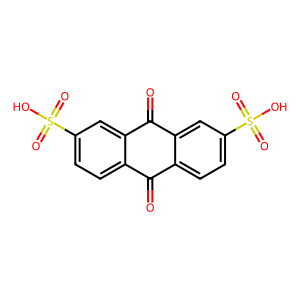
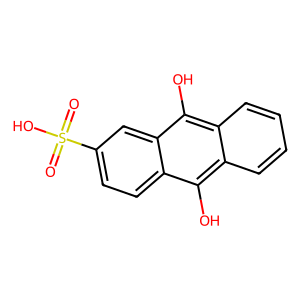
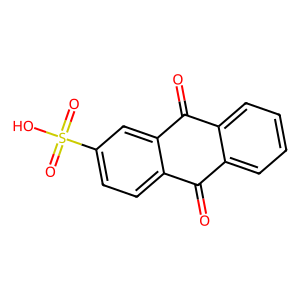
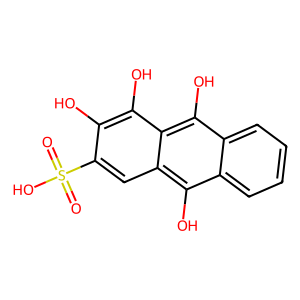
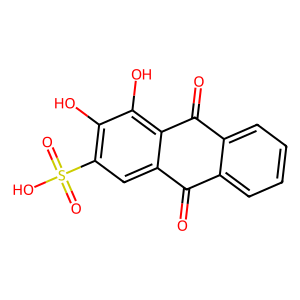
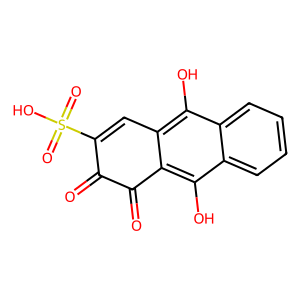
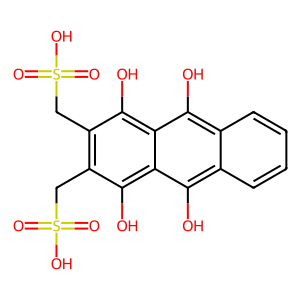
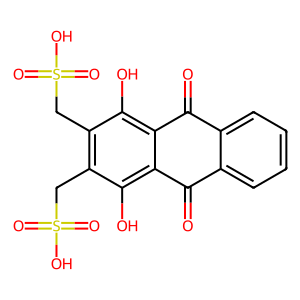
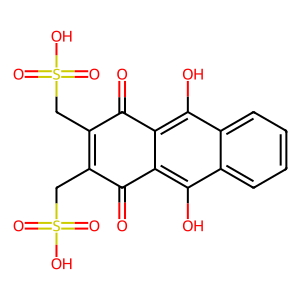
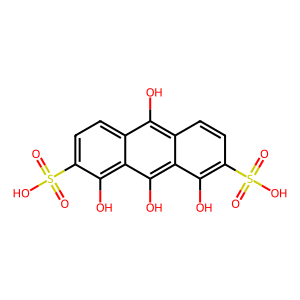
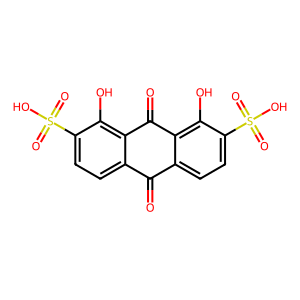
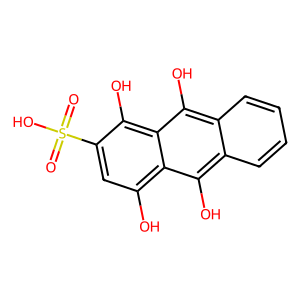
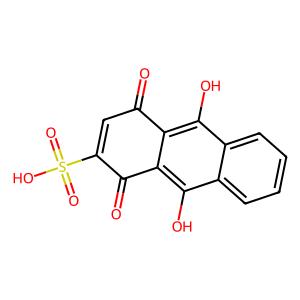
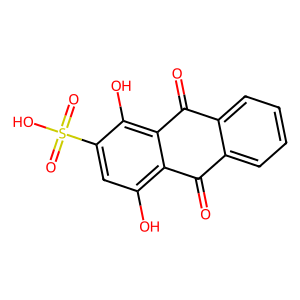
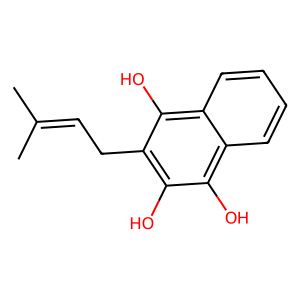
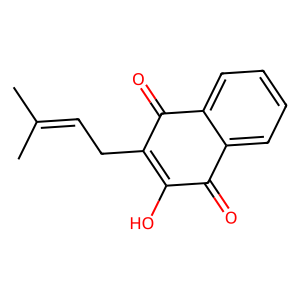
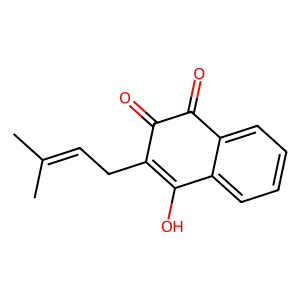
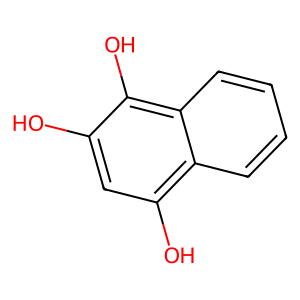
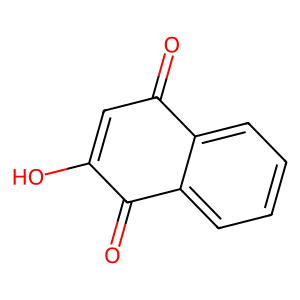
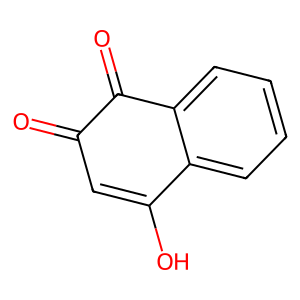
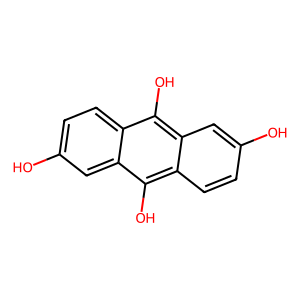
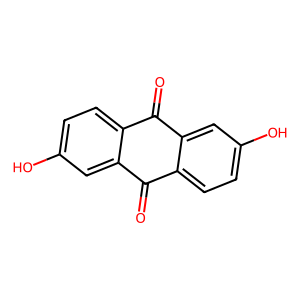
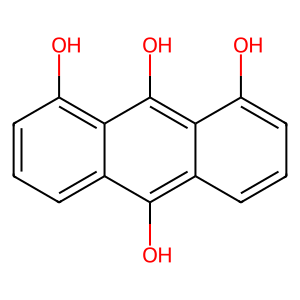
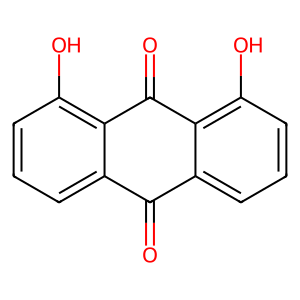
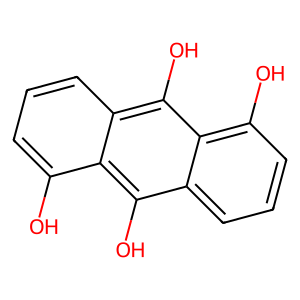
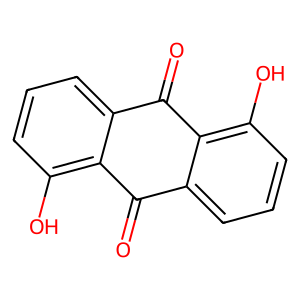
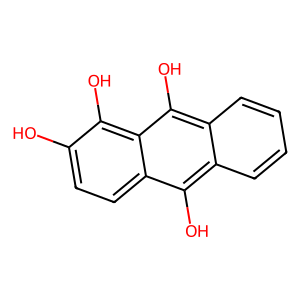
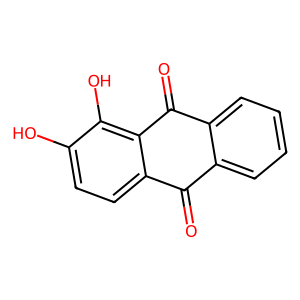
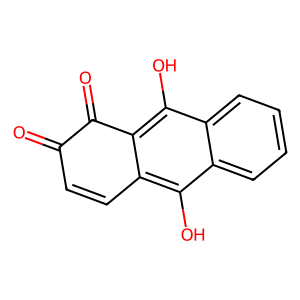
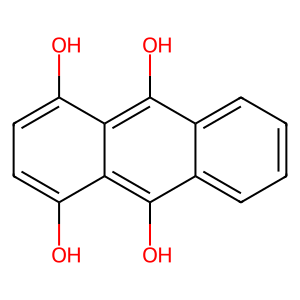
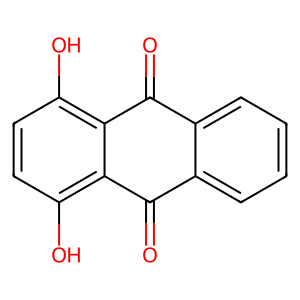
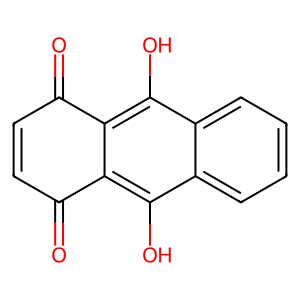
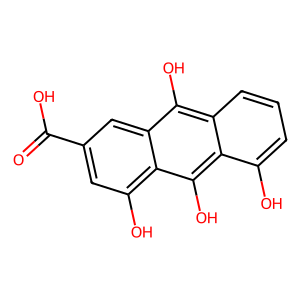
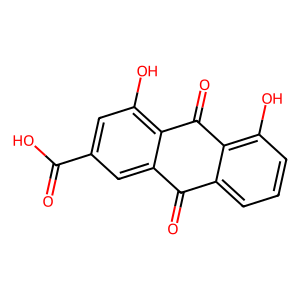
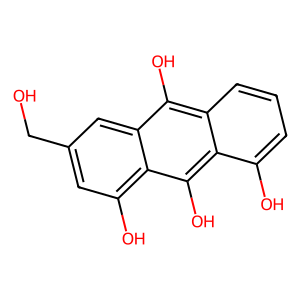
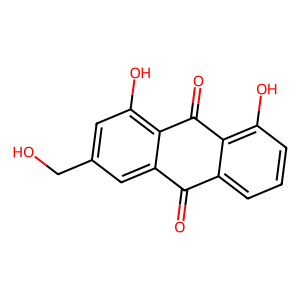
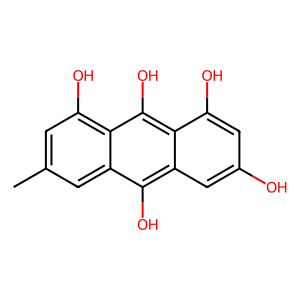
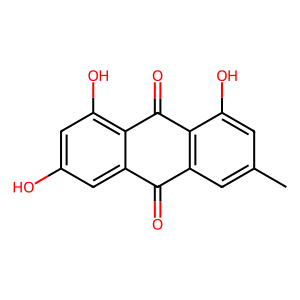
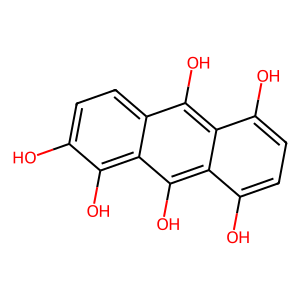
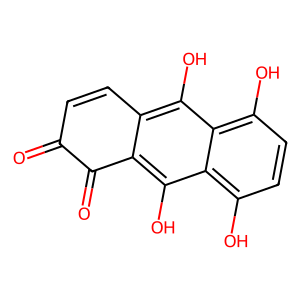
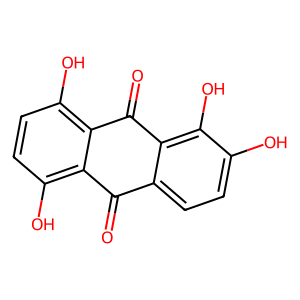
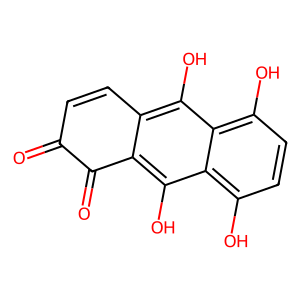
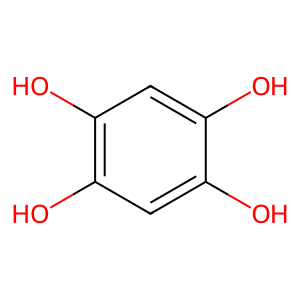
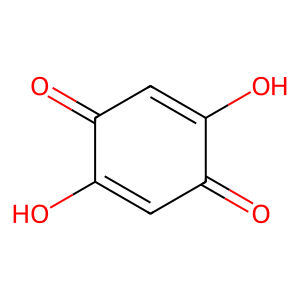
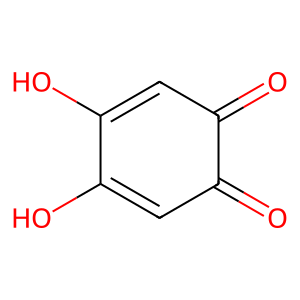
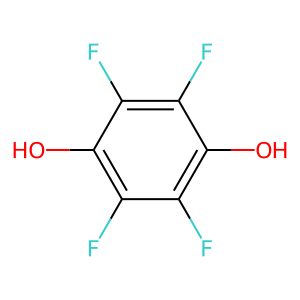
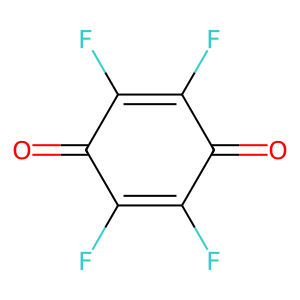
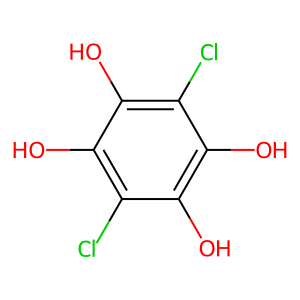
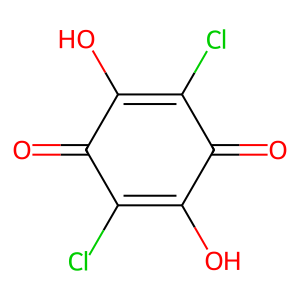
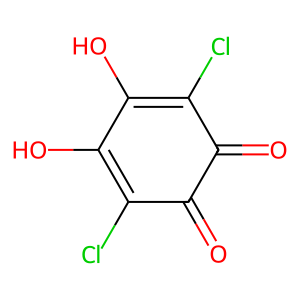
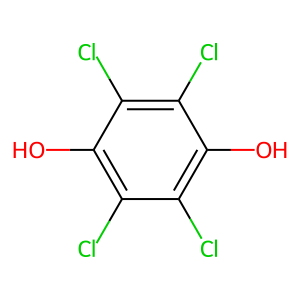
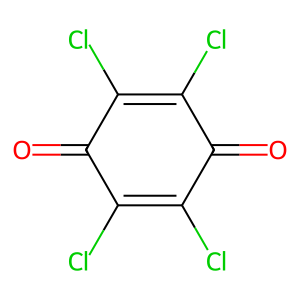
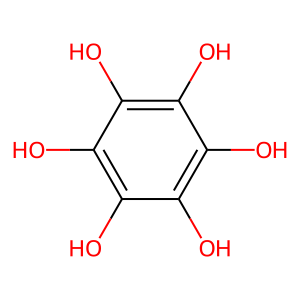
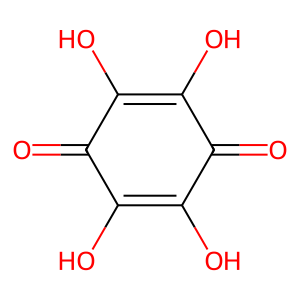
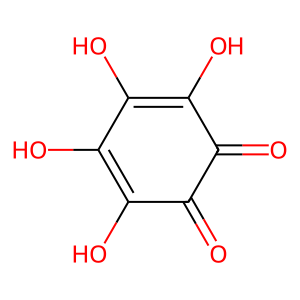
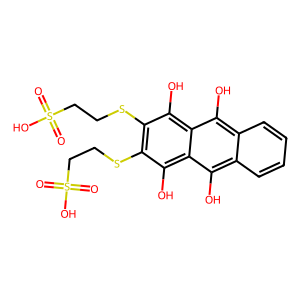
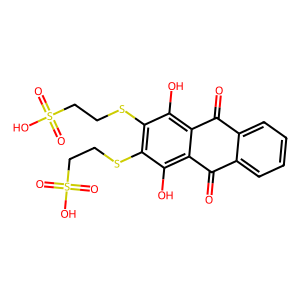
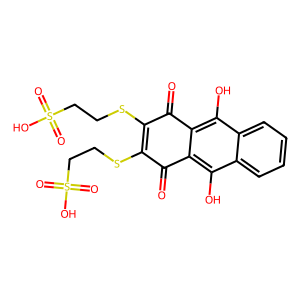
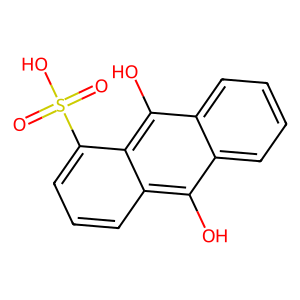
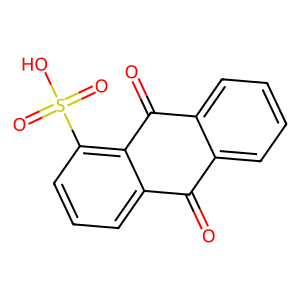
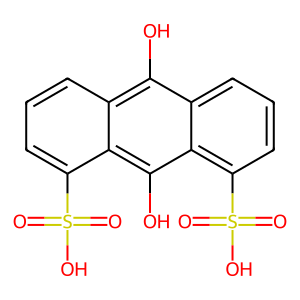
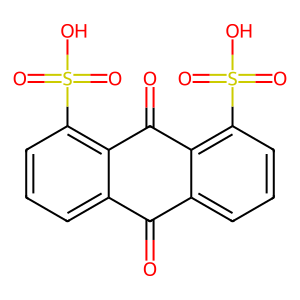
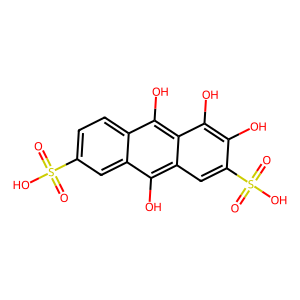
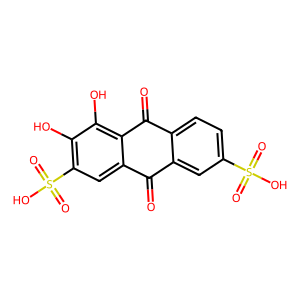
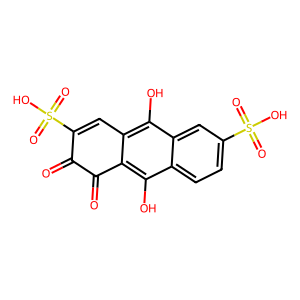
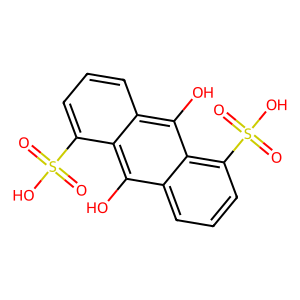
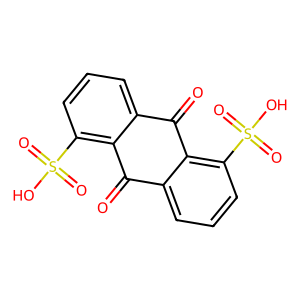
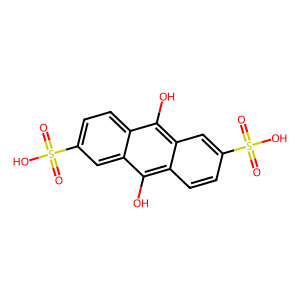
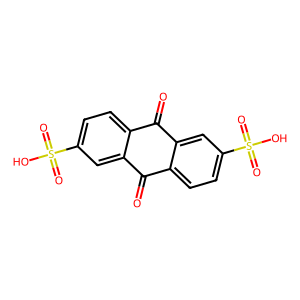
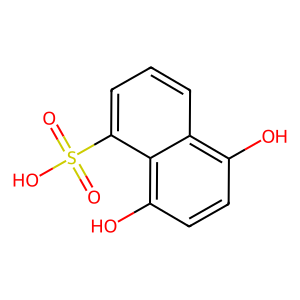
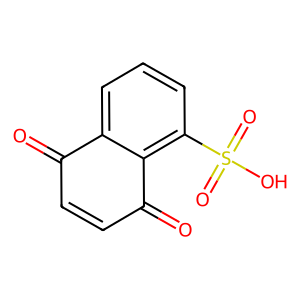
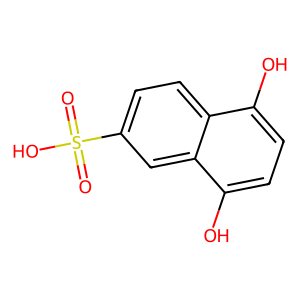
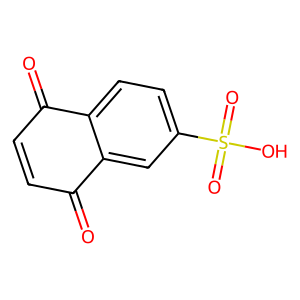
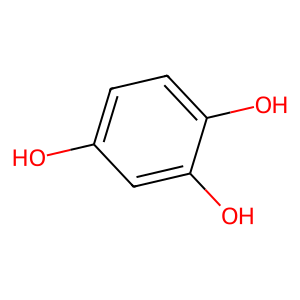
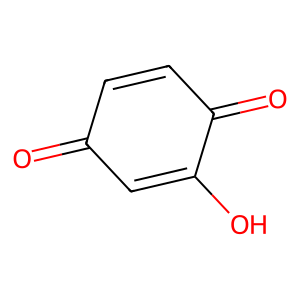
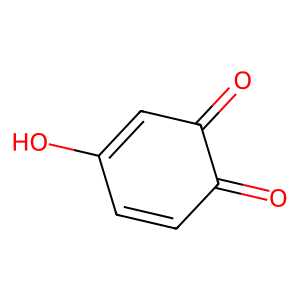
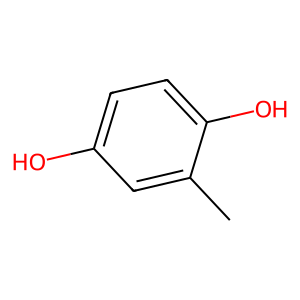
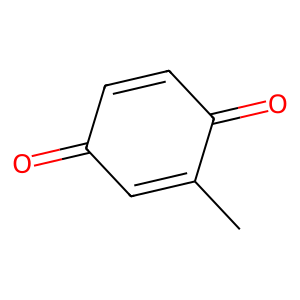
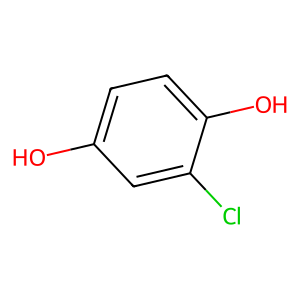
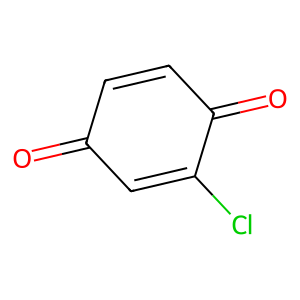
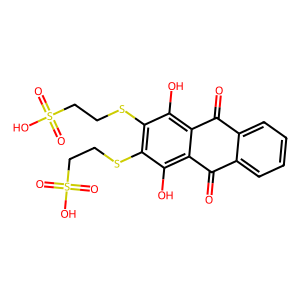
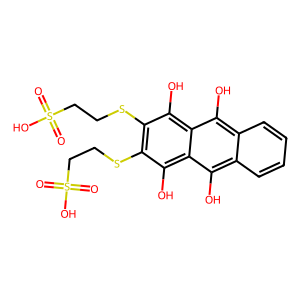
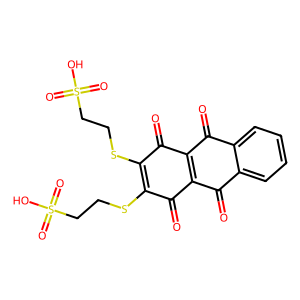
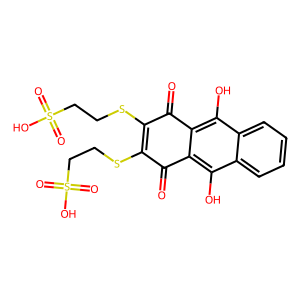
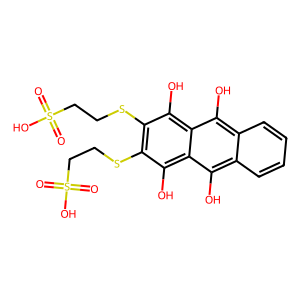
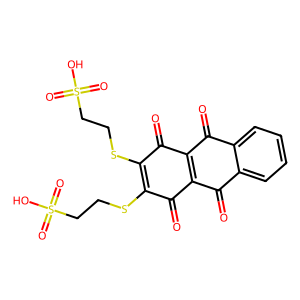
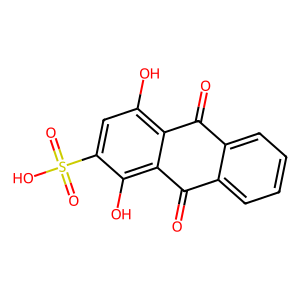
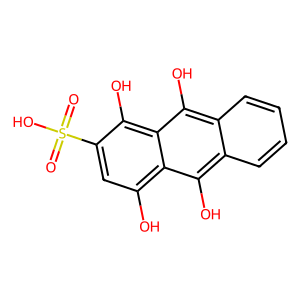
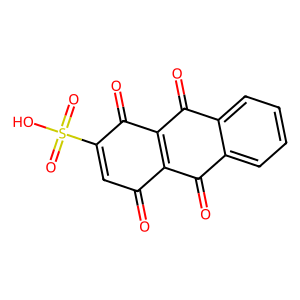
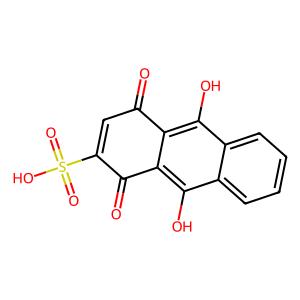
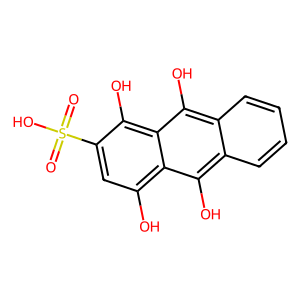
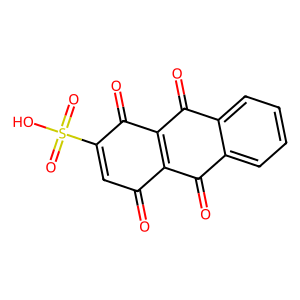

In [4]:
Reactants_Path = './input/Reactants_oxidation.txt'
Pattern_Path = './input/Pattern.txt'

Enum_library_generation(Reactants_Path, Pattern_Path)